Found 2584 images belonging to 16 classes.
Found 1097 images belonging to 16 classes.
Epoch 1/100
41/41 [==============================] - 1270s 31s/step - loss: 3.2414 - accuracy: 0.1734 - val_loss: 1.9909 - val_accuracy: 0.2972 - lr: 1.0000e-04
Epoch 2/100
41/41 [==============================] - 1230s 30s/step - loss: 1.8049 - accuracy: 0.3653 - val_loss: 1.5314 - val_accuracy: 0.4649 - lr: 1.0000e-04
Epoch 3/100
41/41 [==============================] - 1226s 30s/step - loss: 1.3397 - accuracy: 0.5174 - val_loss: 1.1905 - val_accuracy: 0.5688 - lr: 1.0000e-04
Epoch 4/100
41/41 [==============================] - 1220s 30s/step - loss: 1.0380 - accuracy: 0.6335 - val_loss: 1.0901 - val_accuracy: 0.5971 - lr: 1.0000e-04
Epoch 5/100
41/41 [==============================] - 1222s 30s/step - loss: 0.8142 - accuracy: 0.7082 - val_loss: 0.7805 - val_accuracy: 0.7302 - lr: 1.0000e-04
Epoch 6/100
41/41 [==============================] - 1221s 30s/step - loss: 0.6298 - accuracy: 0.7713 - val_l

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as my_model2.h5
18/18 [==============================] - 370s 20s/step - loss: 0.3889 - accuracy: 0.8906
Test Accuracy: 0.8906107544898987
18/18 [==============================] - 381s 21s/step


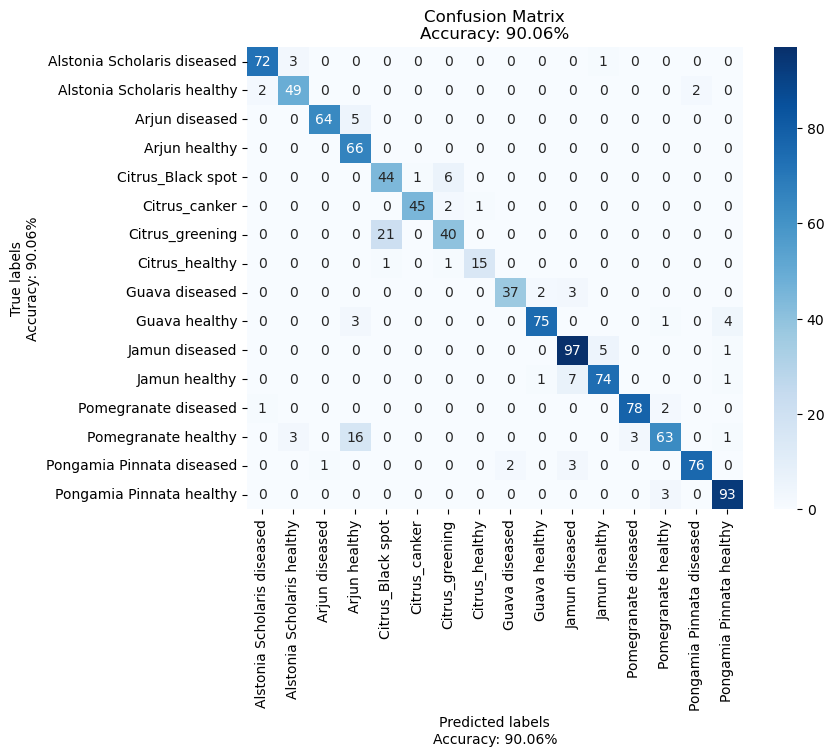

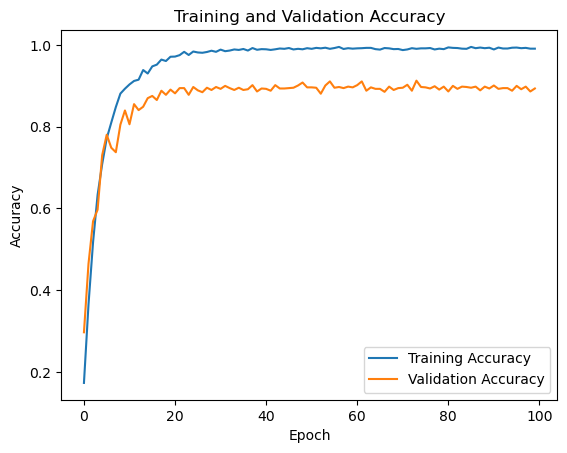

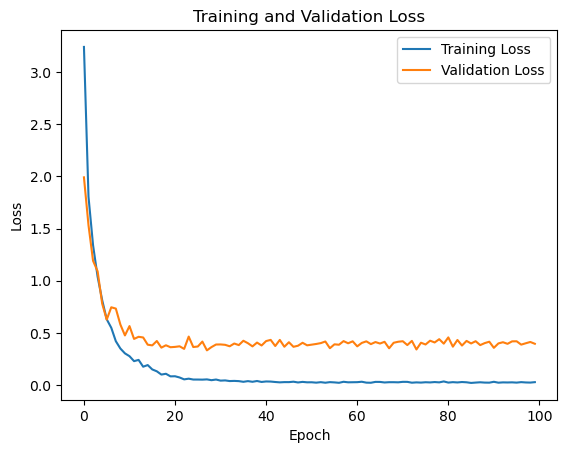

Predicted class name: Alstonia Scholaris diseased
Classification Report:
                              precision    recall  f1-score   support

Alstonia Scholaris diseased       0.96      0.95      0.95        76
 Alstonia Scholaris healthy       0.89      0.92      0.91        53
             Arjun diseased       0.98      0.93      0.96        69
              Arjun healthy       0.73      1.00      0.85        66
          Citrus_Black spot       0.67      0.86      0.75        51
              Citrus_canker       0.98      0.94      0.96        48
            Citrus_greening       0.82      0.66      0.73        61
             Citrus_healthy       0.94      0.88      0.91        17
             Guava diseased       0.95      0.88      0.91        42
              Guava healthy       0.96      0.90      0.93        83
             Jamun diseased       0.88      0.94      0.91       103
              Jamun healthy       0.93      0.89      0.91        83
       Pomegranate diseased 

In [4]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.applications import VGG16

# Define classes
classes = ["Alstonia Scholaris diseased","Alstonia Scholaris healthy","Arjun diseased","Arjun healthy","Citrus_Black spot","Citrus_canker","Citrus_greening","Citrus_healthy","Guava diseased","Guava healthy","Jamun diseased","Jamun healthy","Pomegranate diseased","Pomegranate healthy","Pongamia Pinnata diseased","Pongamia Pinnata healthy"]

# Define the path to the folder containing the images
data_dir = r"C:\Users\user7\Desktop\Crop Doctor\model 2\Dataset"

# Initialize ImageDataGenerator for data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # Splitting the data into training and validation sets with a 70:30 ratio
)

# Load and augment the training data
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resizing images to 224x224 to match the input shape of VGG16
    batch_size=64,
    class_mode='sparse',  # Since we have sparse categorical labels
    shuffle=True,
    subset='training'  # Specify that this is the training set
)

# Load the test data without augmentation
test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    shuffle=False,  # Shuffle the test data to ensure randomness in evaluation
    subset='validation'  # Specify that this is the validation set
)

# Load the VGG16 model with pretrained weights on ImageNet
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the VGG16 model
for layer in vgg_model.layers:
    layer.trainable = False

# Unfreeze some of the higher layers for fine-tuning
for layer in vgg_model.layers[-4:]:
    layer.trainable = True

# Define custom classification layers
x = layers.Flatten()(vgg_model.output)
x = layers.Dense(4096, activation='relu', name='fc6')(x)
x = layers.Dropout(0.5)(x)  # Add dropout layer
x = layers.Dense(4096, activation='relu', name='fc7')(x)
x = layers.Dropout(0.5)(x)  # Add dropout layer
output = layers.Dense(len(classes), activation='softmax', name='predictions')(x)  # Output layer adjusted to match number of classes

# Create the model
model = models.Model(vgg_model.input, output)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Fit the model
history = model.fit(
    train_generator,
    epochs=100,  # Adjust epochs based on experimentation and validation performance
    validation_data=test_generator,
    callbacks=[lr_callback]
)

# Save the model
model.save("my_model2.h5")

print("Model saved as my_model2.h5")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

# Get the predicted classes for the test data
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Get true labels
y_true = test_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
accuracy_percentage = accuracy * 100

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel(f'Predicted labels\nAccuracy: {accuracy_percentage:.2f}%')
plt.ylabel(f'True labels\nAccuracy: {accuracy_percentage:.2f}%')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy_percentage:.2f}%')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Get the predicted class name
predicted_class_name = classes[y_pred[3]]
print("Predicted class name:", predicted_class_name)

# Get classification report
classification_rep = classification_report(y_true, y_pred, target_names=classes)

# Print classification report
print("Classification Report:\n", classification_rep)
